In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# wrangling
import pandas as pd
import numpy as np

# preparing
from sklearn.model_selection import train_test_split

# visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# exploring
import scipy.stats as stats
import pandas_profiling

# modeling
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression
from math import sqrt
from sklearn.neighbors import KNeighborsRegressor

# 3D projection
from mpl_toolkits.mplot3d import Axes3D

pd.options.display.float_format = '{:20,.2f}'.format

# my modules
import acquire
import summarize
import prepare

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

## Acquire

- 2017 data

- Used only latest transaction property id.

- Used only properties with single family homes.

- Acquired zillow data using acquire.py (sequel query in this file)

- Exported df to a csv file for faster loading.

In [2]:
# df = acquire.get_zillow_data()
# df.head()

In [3]:
# Reads in a df with 52,169 rows and 21 columns

df = pd.read_csv("zillow_dataframe.csv")

In [4]:
df.shape

(52169, 21)

----

## Prepare

- Starting stage with 52,169 rows and 19 columns

- This stage will be revisted often as data needs dictate.


- Drop columns not needed based on previous and ongling exploration:

    - "Unnamed: 0", "garagetotalsqft", "poolsizesum", "taxdelinquencyflag", "taxdelinquencyyear", "transactions"
    
    
- Keep garagecacnt and poolcnt for exploration and possible feature engineering purposed.

- Manually scale latitude and longitude by dividing by 1 million.


- Create the following new variables for exploration and modeling

    - price_per_sq_ft: (value of house / house square footage)
    
    - land_price_per_sq_ft: (land tax value / lot square footage)
    
    - cluster: Los Angeles == 0, Ventura == 1, Orange == 2
    
    
- Split data into train and test
    
    
- Fill zeros for missing values in garagecarcnt and poolcnt

    - explore these columns for possible feature engineering in this or future iterations of project
    
    
- Drop remaining rows with Nulls to get data ready to model
    - train df
        - lotsizesquarefeet               251
        - yearbuilt                        26
        - price_per_sq_ft                   3
        - lot_price_per_sq_ft             251
    - test df
        - tax_rate                          1
        - calculatedfinishedsquarefeet      5
        - lotsizesquarefeet               103
        - taxvaluedollarcnt                 1
        - yearbuilt                        14
        - landtaxvaluedollarcnt             1
        - price_per_sq_ft                   6
        - lot_price_per_sq_ft             104


- Final train and test df sizes at the end of prepare-  

    - train = (36238, 20)
    - test = (15532, 20)
    
    

In [5]:
# drop columns that will not be needed for explore or model

df = df.drop(columns=["Unnamed: 0", "garagetotalsqft", "poolsizesum", "taxdelinquencyflag", "taxdelinquencyyear", "transactions"])

In [6]:
df.shape

(52169, 15)

In [7]:
# Manually scale lat and long from very large numbers by dividing by 1 million

df.latitude = df.latitude / 1_000_000 
df.longitude = df.longitude / 1_000_000 

In [8]:
df['price_per_sq_ft'] = df['taxvaluedollarcnt'] / df['calculatedfinishedsquarefeet']
df['lot_price_per_sq_ft'] = df['landtaxvaluedollarcnt'] / df['lotsizesquarefeet']

In [9]:
df.head(1)

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,logerror,county_name,price_per_sq_ft,lot_price_per_sq_ft
0,0.01,3.50,4.00,"3,100.00","6,059.00",2.00,33.63,-117.87,"4,506.00",nan,"1,023,282.00","1,998.00","537,569.00",0.03,Orange,330.09,119.30


In [10]:
# df = df.drop(columns=['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt'])

### Clustering fips - aka binning the 3 different counties

In [11]:
from sklearn.cluster import KMeans

X = df[['fips']]

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

X['cluster'] = pd.Series(kmeans.predict(X)).astype(str)

In [12]:
X.shape

(52169, 2)

In [13]:
# Drop column no longer necessary

X = X.drop(columns='fips')

In [14]:
# Create column with county clusters identified

df['cluster'] = X.cluster

In [15]:
df, ohe = prepare.encode(df, 'cluster')

In [16]:
ohe.inverse_transform(df[['0', '1', '2']])

array([[0],
       [2],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [17]:
# Los Angeles == 0, Ventura == 1, Orange == 2

df = df.drop(columns='cluster')

df['los_angeles'] = df['0']
df['ventura'] = df['1']
df['orange'] = df['2']

df = df.drop(columns=['0', '1', '2'])

### Split the data into train and test, 70/30

In [18]:
train, test = train_test_split(df, test_size=.30, random_state=123)

In [19]:
train.shape

(36518, 20)

In [20]:
test.shape

(15651, 20)

### Impute "poolcnt", "garagecarcnt" with zeros

 - Run this on train and test subsets separately

In [21]:
# Impute zeros into poolcnt and garagecarcnt on train set

train.poolcnt.fillna(value=0, inplace=True)
test.poolcnt.fillna(value=0, inplace=True)

In [22]:
# Impute zeros into poolcnt and garagecarcnt on test set
train.garagecarcnt.fillna(value=0, inplace=True)
test.garagecarcnt.fillna(value=0, inplace=True)

### Drop the remaining Nulls in df to get clean train and test data sets

In [23]:
train.dropna(inplace=True)

In [24]:
test.dropna(inplace=True)

### THE train and test subsets with no missing values and poolcnt and garagecarcnt imputed with zeros. Outliers still in these subsets!

- I left county_name in these df for ease of exploration and viz. 

- Drop county_name and use fips for modeling and clustering purposes.

- If you want train and test with defined categories and outliers handled, see train_cat and test_cat below

In [25]:
train.isnull().sum()
train.shape

(36238, 20)

In [26]:
test.isnull().sum()
test.shape

(15532, 20)

----

## Explore 

### Quick Look with Heatmap

In [28]:
# do a quick drop of the columns below just for this heat map. They are just clutter here.

heatmap_df = train.drop(columns=['los_angeles', 'orange', 'ventura', 'fips'])

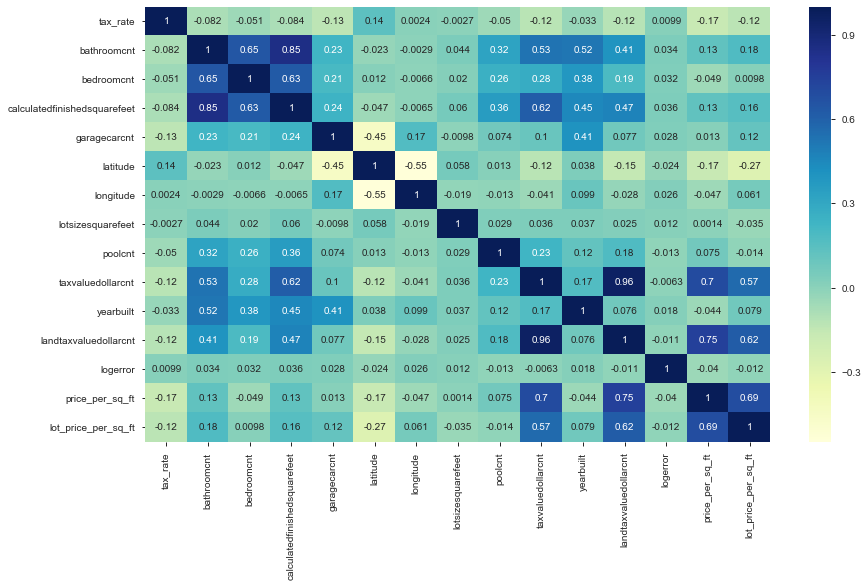

In [29]:
plt.figure(figsize=(14,8))
sns.heatmap(heatmap_df.corr(), annot=True, cmap="YlGnBu")

### Takeaways from Heatmap

- There is nothing highly correlated with logerror.

- The new columns price_per_sq_ft and lot_price_per_sq_ft have more of a correlation with logerror than the more general columns they are based on, taxvaluedollarcnt and landtaxvaluedollarcnt.

---

### Explore bedroom

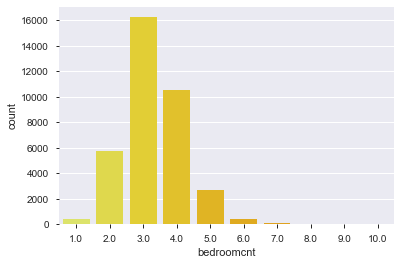

In [30]:
sns.countplot(x='bedroomcnt', palette="Wistia", data=train)
plt.show()

In [31]:
train.bedroomcnt.value_counts()

 3.00    16241
 4.00    10523
 2.00     5784
 5.00     2726
 6.00      446
 1.00      418
 7.00       72
 8.00       20
 9.00        6
10.00        2
Name: bedroomcnt, dtype: int64

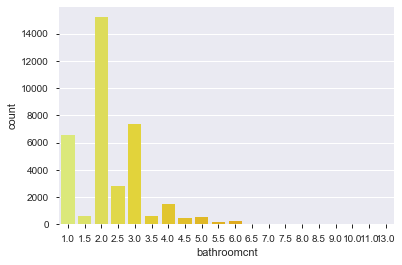

In [32]:
sns.countplot(x='bathroomcnt', palette="Wistia", data=train)
plt.show()

In [33]:
train.bathroomcnt.value_counts()

 2.00    15201
 3.00     7392
 1.00     6584
 2.50     2800
 4.00     1522
 3.50      628
 1.50      573
 5.00      525
 4.50      481
 6.00      209
 5.50      160
 7.00       57
 8.00       40
 6.50       35
 7.50       14
 9.00       10
10.00        3
11.00        2
 8.50        1
13.00        1
Name: bathroomcnt, dtype: int64

### Before outliers

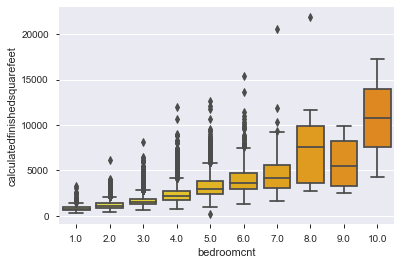

In [34]:
sns.boxplot(train.bedroomcnt, train.calculatedfinishedsquarefeet, palette="Wistia")

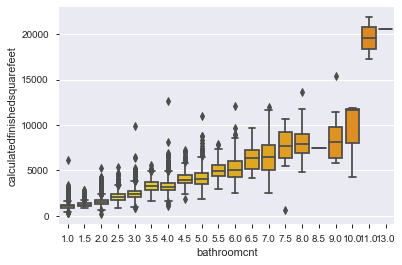

In [35]:
sns.boxplot(train.bathroomcnt, train.calculatedfinishedsquarefeet, palette="Wistia")

### Takeaways from bathroom and bedrooms counts

- Use remove_outliers_iqr to drop rows with bedroom or bathroom counts outside upper and lower bounds

    - Upper bound = Q3 + 1.5 * IQR
    - Lower bound = Q1 - 1.5 * IQR

---

### Handle outliers by removing values < Q1 - IQR * 1.5 and values > Q3 + IQR * 1.5

In [36]:
train = prepare.remove_outliers_iqr(train, columns=["bedroomcnt", "bathroomcnt", "lotsizesquarefeet"], k=1.5)

In [37]:
test = prepare.remove_outliers_iqr(test, columns=["bedroomcnt", "bathroomcnt", "lotsizesquarefeet"], k=1.5)
test.shape

(13258, 20)

### After handling outliers above 5 bedrooms and 4.5 bathrooms

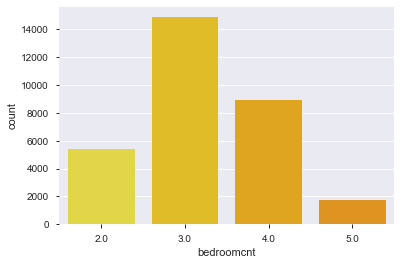

In [38]:
sns.countplot(x='bedroomcnt', palette="Wistia", data=train)
plt.show()

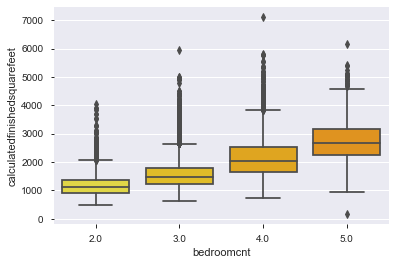

In [39]:
sns.boxplot(train.bedroomcnt, train.calculatedfinishedsquarefeet, palette="Wistia")

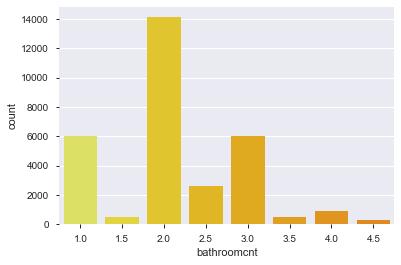

In [40]:
sns.countplot(x='bathroomcnt', palette="Wistia", data=train)
plt.show()

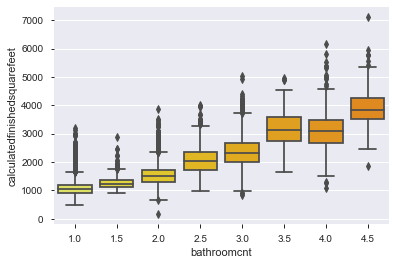

In [41]:
sns.boxplot(train.bathroomcnt, train.calculatedfinishedsquarefeet, palette="Wistia")

In [42]:
train.bedroomcnt.value_counts()

3.00    14870
4.00     8892
2.00     5417
5.00     1770
Name: bedroomcnt, dtype: int64

In [43]:
train.bathroomcnt.value_counts()

2.00    14112
1.00     6025
3.00     6003
2.50     2592
4.00      932
3.50      491
1.50      467
4.50      327
Name: bathroomcnt, dtype: int64

---

### Does price_per_sq_ft offer a better view of logerror?

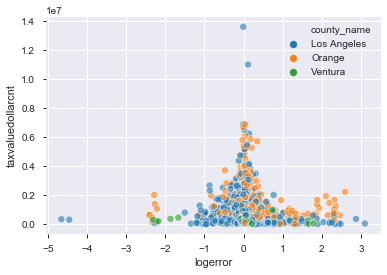

In [44]:
sns.scatterplot(data=train, x="logerror", y="taxvaluedollarcnt", hue="county_name", hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6)

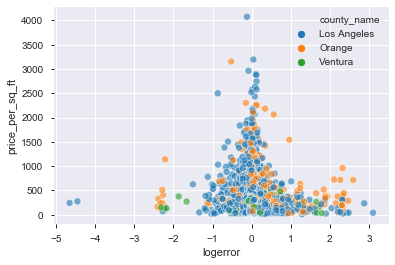

In [45]:
sns.scatterplot(data=train, x="logerror", y="price_per_sq_ft", hue="county_name", hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6)

### Takeaways from logerror by county using price_per_sq_ft

- Using price_per_sq_ft instead of taxvaluedollarcnt offers better insight into logerror.


- Zillow's log error was low on the los angeles high priced outlier.  LA county houses seems to have the highest log error outliers

---

### Explore variable relationships with new feature price_per_sq_ft

In [190]:
train.groupby(['county_name']).logerror.value_counts()

county_name  logerror
Los Angeles   0.00       4
              0.00       4
              0.00       4
              0.00       3
              0.00       3
              0.01       3
              0.01       3
              0.01       3
              0.02       3
              0.02       3
             -0.22       2
             -0.02       2
             -0.02       2
             -0.02       2
             -0.02       2
             -0.01       2
              0.00       2
              0.00       2
              0.00       2
              0.00       2
              0.00       2
              0.00       2
              0.00       2
              0.00       2
              0.00       2
              0.00       2
              0.00       2
              0.00       2
              0.01       2
              0.01       2
                        ..
Ventura       0.35       1
              0.35       1
              0.37       1
              0.37       1
              0.37       1
      

In [193]:
%%writefile myviz.py
clist = []
labels = []

for county in train.county_name.unique():
    clist.append(train[train.county_name == county].logerror)
    labels.append(county)

plt.hist(clist, color=['orange', 'dodgerblue', 'green'], label=labels)
plt.legend()
plt.show()

Writing myviz.py


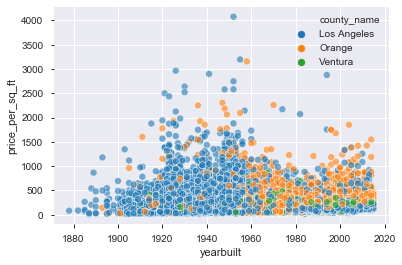

In [46]:
sns.scatterplot(data=train, x="yearbuilt", y="price_per_sq_ft", hue='county_name', hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6)

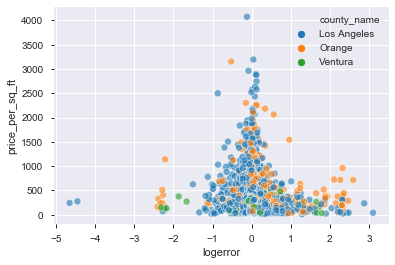

In [56]:
sns.scatterplot(data=train, y="price_per_sq_ft", x="logerror", hue='county_name', hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6)

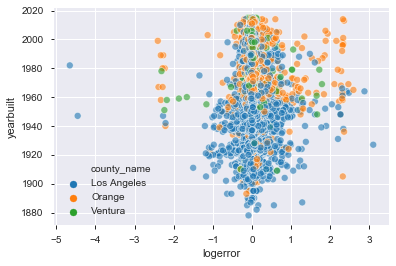

In [57]:
sns.scatterplot(data=train, y="yearbuilt", x="logerror", hue='county_name', hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6)

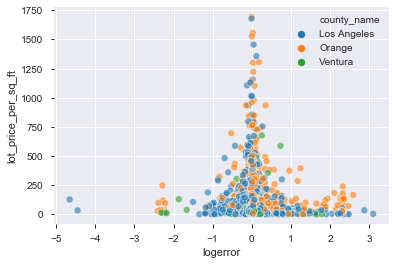

In [58]:
sns.scatterplot(data=train, y="lot_price_per_sq_ft", x="logerror", hue='county_name', hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6)

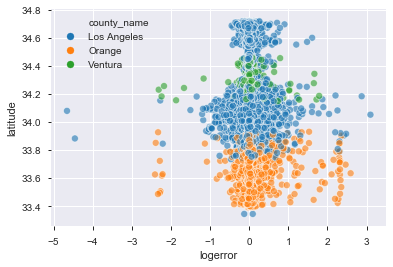

In [59]:
sns.scatterplot(data=train, y="latitude", x="logerror", hue='county_name', hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6)

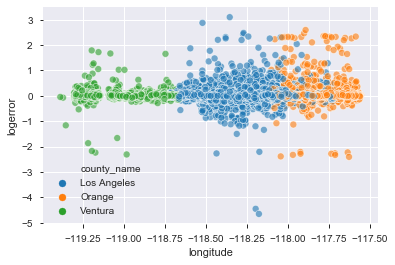

In [63]:
sns.scatterplot(data=train, x="longitude", y="logerror", hue='county_name', hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6)

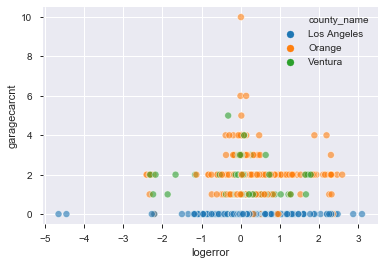

In [64]:
sns.scatterplot(data=train, y="garagecarcnt", x="logerror", hue='county_name', hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6)

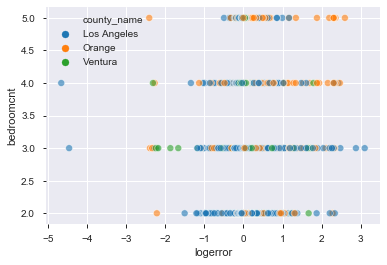

In [65]:
sns.scatterplot(data=train, y="bedroomcnt", x="logerror", hue='county_name', hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6)

---

---

## Stats Testing to Decide on Feature Engineering

### Chi2 test to looking at bedroom and bathroom counts

- $H_0$: Bathroomcnt is independent of how many bedrooms a home has.

- $H_a$: Bathroomcnt is not independent of how many bedrooms a home has.

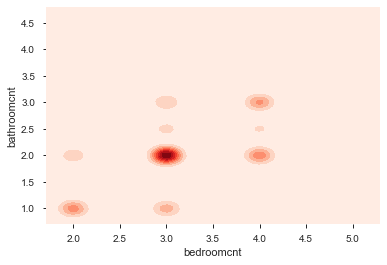

In [169]:
# kernal density estimate (kde) chart to show most common combination of bed and bath count

sns.kdeplot(train.bedroomcnt, train.bathroomcnt, shade=True, cmap='Reds')
plt.show()

In [170]:
# contingency_table from the df_cat dataframe (w/o categories)

contingency_table = pd.crosstab(train.bedroomcnt, train.bathroomcnt).style.background_gradient(cmap='YlOrRd')
contingency_table

bathroomcnt,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5
bedroomcnt,,,,,,,,
2.0,3408,101,1619,127,149,8,5,0
3.0,2449,294,8703,1272,1836,124,172,20
4.0,149,71,3574,1079,3137,277,445,160
5.0,19,1,216,114,881,82,310,147


In [171]:
contingency_table = pd.crosstab(train.bedroomcnt, train.bathroomcnt)
_, p, _, expected = stats.chi2_contingency(contingency_table)

In [172]:
print(f"The p-value of the contingency test is {p}.")

The p-value of the contingency test is 0.0.


### Takeaways from chi2 test on bedroomcnt and bathroomcnt

- The typical home is a 3 bedroom, 2 bathroom. This is where the most variation will lie making it the most difficult home values to predict.


- Based on the p_value of 0 from the chi2 test above, I reject the Null Hypothesis that bathroomcnt is independent of how many bedrooms a home has.


- Based on rejecting the Null Hypothesis, it might be useful to combine the two features into a single feature that is a ratio of bedrooms to bathrooms. This may be done in this or a future iteration of this project.

---

### Chi2 test looking at garagecarcnt and poolcnt

- $H_0$: garagecarcnt is independent of how many pools a home has.

- $H_a$: garagecarcnt is not independent of how many pools a home has.

In [173]:
contingency_table = pd.crosstab(train.garagecarcnt, train.poolcnt).style.background_gradient(cmap='YlOrRd')
contingency_table

poolcnt,0.0,1.0
garagecarcnt,,
0.0,16820,3104
1.0,1242,140
2.0,7456,1945
3.0,121,77
4.0,22,17
5.0,2,0
6.0,2,0
10.0,1,0


In [174]:
contingency_table = pd.crosstab(train.garagecarcnt, train.poolcnt)

In [175]:
_, p, _, expected = stats.chi2_contingency(contingency_table)

In [176]:
print(f"The p-value of the contingency test is {p}.")

The p-value of the contingency test is 9.067411034211706e-51.


In [177]:
r, p = stats.pearsonr(train.lotsizesquarefeet, train.taxvaluedollarcnt)

In [178]:
print(f"r is {r}")

r is 0.06814290378709685


In [179]:
print(f"p is {p}")

p is 3.493798119498479e-33


### Takeaways from chi2 test on bedroomcnt and bathroomcnt

- Most homes do not have a pool or a garage.

- Two car garages are the most common and one pool.

- Since each of these variables would add value to the home value but both have so many missing values, there could be an opportunity for feature engineering combining these two variables into a single column called 'extras'.

---

## DB Scan this thingy

In [ ]:
sns.scatterplot(data=train, y="price_per_sq_ft", x="lot_price_per_sq_ft", hue="county_name")

---

## Split train and test 

- into X_train, X_test, y_train, y_test

In [ ]:
train = train.drop(columns='county_name')
test = test.drop(columns='county_name')

In [ ]:
df = df.drop(columns=['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'yearbuilt'])

In [ ]:
X_train = train.drop(columns="logerror")

y_train = train[["logerror"]]

X_test = test.drop(columns="logerror")

y_test = test[["logerror"]]

---

## Model 

### Linear Regression Model

In [ ]:
X_train.dtypes

In [ ]:
X_train.head()

In [ ]:
X_train.garagecarcnt = X_train.garagecarcnt.astype(float)
X_train.bathroomcnt = X_train.bathroomcnt.astype(float)
X_train.bedroomcnt = X_train.bedroomcnt.astype(float)
X_train.poolcnt = X_train.poolcnt.astype(float)

In [ ]:
X_train = X_train.drop(columns='yearbuilt')
X_test = X_test.drop(columns='yearbuilt')

In [ ]:
# create the LR object

lm1 = LinearRegression()
print(lm1)

In [ ]:
# fit/train the model

model = lm1.fit(X_train, y_train)

In [ ]:
# create yhat variable, numpy array, in-sample prediction values

yhat = model.predict(X_train)
yhat

In [ ]:
actual = y_train
actual.head()

In [ ]:
actual['yhat'] = yhat

#### this needs work ... Evaluate LR Model

In [ ]:
actual["residual"] = actual["yhat"] - actual["logerror"]

In [ ]:
sns.distplot(actual["residual"])

In [ ]:
sns.scatterplot(actual["logerror"], actual["yhat"])

In [ ]:
actual["residual^2"] = actual["residual"] ** 2

In [ ]:
sse = sum(actual["residual^2"])
print(f"sse = {sse}")
mse = sse / len(actual)
print(f"mse = {mse}")
rmse = sqrt(mse)
print(f"rmse = {rmse}")

In [ ]:
df_eval = pd.DataFrame(np.array(["SSE", "MSE", "RMSE"]), columns=["metric"])
df_eval["model_error"] = np.array([sse, mse, rmse])
df_eval

- Create a numpy array from the y_df_nums_train df, so I can run eval metrics using yhat(prediction array) and y_array (array of actual y values)

In [ ]:
y_array = np.array(y_train)
type(y_array)

In [ ]:
r2_score(actual.logerror, actual.yhat)

In [ ]:
mse_lm1 = mean_squared_error(actual.logerror, actual.yhat)
print("linear model\n  mean squared error: {:.3}".format(mse_lm1)) 

r2_lm1 = r2_score(actual.logerror, actual.yhat)
print('  {:.2%} of the variance in the logerror can be explained by variables.'.format(r2_lm1))

#### Takeaways from the Linear Regression Model:

- Based on the results above I fail to reject the Null Hypothesis that the numeric values alone can predict the logerror.

- Using a Linear Regression model to predict the logerror may not be the best choice.

- Finding a way to include categorical variables in a model may help predict logerror.

---

### Model - K Neighbors Regressor

In [ ]:
# create the object
neigh = KNeighborsRegressor(n_neighbors=2)

In [ ]:
# fit/train the model using train 
neigh.fit(X_train, y_train)

In [ ]:
yhat = neigh.predict(X_train)
type(yhat)

#### Evaluate KNeighbors Regression

In [ ]:
r2 = neigh.score(X_train, y_train)

In [ ]:
print('  {:.2%} of the variance in the logerror can be explained by variables.'.format(r2))

#### Takeaways from KNRegressor Model

- This model explained more than 40% more of the variance in logerror than my LR model using exactly the same data.

- The subset of data I used was comprised of the numeric values only from the original dataframe.

- I think this model could do even better with outliers handled and some feature engineering.

---

### Model df - Random Forest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
rf = RandomForestRegressor(n_estimators=10)

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = rf.predict(X_train)
print(f'root mean squared error = {mean_squared_error(y_train, y_pred)**1/2}')

In [ ]:
y_pred = rf.predict(X_test)
print(f'root mean squared error = {mean_squared_error(y_test, y_pred)**1/2}')

### PUT TAKEAWAYS FROM RANDOM FOREST MODEL HERE

In [ ]:
predictions_vs_actual = pd.DataFrame({'predictions_log_error': y_pred, 'actual_log_error': y_test.logerror})

In [ ]:
sns.scatterplot(data=predictions_vs_actual, x='predictions_log_error', y='actual_log_error', hue="cluster")